In [1]:
import numpy as np
import math, random

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from geometry.model import Model, combine_observations, get_mesh
from geometry.utils.visualisation import illustrate_points, illustrate_mesh, illustrate_voxels
from geometry.voxel_grid import VoxelGrid

from rl.environment import Environment, CombiningObservationsWrapper
from rl.environment import StepPenaltyRewardWrapper, DepthMapWrapper
from rl.environment import VoxelGridWrapper, VoxelWrapper
from rl.environment import FrameStackWrapper, ActionMaskWrapper
from rl.environment import FinalRewardWrapper


from rl.dqn import CnnDQN, CnnDQNA, VoxelDQN
from rl.utils import DiskReplayBuffer, ReplayBuffer


# !conda install -c conda-forge pyembree
# !conda install -c conda-forge igl
# !pip install Cython
# !pip install gym

In [2]:
def plot(frame_idx, rewards, novps, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('number of vp: %s' % np.mean(novps[-10:]))
    plt.plot(novps)
    plt.subplot(133)
    plt.title('loss')
    if len(losses) > 20:
        plt.plot(losses[20:])
    else:
        plt.plot(losses)
    plt.show()

## DQN

In [3]:
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    torch.cuda.set_device(0)
    print(torch.cuda.current_device())

In [6]:
env = Environment(illustrate=False, model_path="./data/Dude.obj", number_of_view_points=100)
# env = CombiningObservationsWrapper(env)
# env = StepPenaltyRewardWrapper(env, weight=1.0)
# env = DepthMapWrapper(env)

env = FinalRewardWrapper(env, illustrate=True)
env = VoxelGridWrapper(env)
env = CombiningObservationsWrapper(env)
env = VoxelWrapper(env)
env = StepPenaltyRewardWrapper(env)
env = FrameStackWrapper(env, num_stack=4, lz4_compress=False)
env = ActionMaskWrapper(env)

/opt/conda/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
state, _, mask = env.reset()
for frame_idx in range(4):
    action = env.action_space.sample()
    next_state, reward, done, _, mask = env.step(action)

unable to load materials from: FinalBaseMesh.mtl
specified material (default)  not loaded!


0.3227646265178462 0.23361493030845826 0.5563795568263045
0.23361493030845826
0.3052455128991373 0.25113404392716715 0.5563795568263045
0.25113404392716715
0.2434073347234147 0.45753977035163895 0.7009471050750536
0.45753977035163895
0.33580686046036223 0.47057269636594223 0.8063795568263045
0.47057269636594223


In [8]:
env.final_reward()

Output()

0.42012922249897366

In [6]:
illustrate_voxels(next_state)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0, 0…

In [12]:
from rl.dqn import CnnDQN, CnnDQNA

model = VoxelDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    model = model.cuda()

replay_initial = 1000
replay_buffer = DiskReplayBuffer(capacity=100000,
                                 overwrite=True,
                                 location="buffer_voxels/",
                                 num_actions=env.action_space.n,
                                 observation_dtype=env.observation_space.dtype,
                                 observation_shape=env.observation_space.shape)

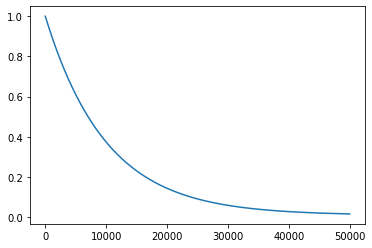

In [6]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 10000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * \
        math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(50000)])

### Training

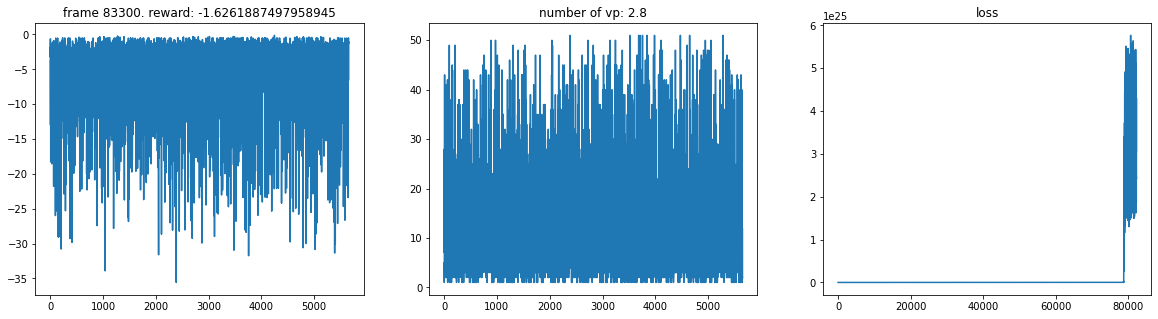

Action:  63
0.3790706183680937 0.43607320565897906 0.8151438240270727
0.43607320565897906
Action:  63
0.3790706183680937 0.43607320565897906 0.8151438240270727
0.43607320565897906
Action:  63
0.3790706183680937 0.43607320565897906 0.8151438240270727
0.43607320565897906
Action:  63
0.3790706183680937 0.43607320565897906 0.8151438240270727
0.43607320565897906
Action:  63
0.3790706183680937 0.43607320565897906 0.8151438240270727
0.43607320565897906
Action:  63
0.3790706183680937 0.43607320565897906 0.8151438240270727
0.43607320565897906
Action:  63
0.3790706183680937 0.43607320565897906 0.8151438240270727
0.43607320565897906
Action:  63
0.3790706183680937 0.43607320565897906 0.8151438240270727
0.43607320565897906
Action:  63
0.3790706183680937 0.43607320565897906 0.8151438240270727
0.43607320565897906
Action:  63
0.3790706183680937 0.43607320565897906 0.8151438240270727
0.43607320565897906
Action:  63
0.3790706183680937 0.43607320565897906 0.8151438240270727
0.43607320565897906
Action:  6

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Action:  63
0.47191198533088846 0.46993622268035534 0.9418482080112438
0.46993622268035534
Action:  63
0.47187031171861976 0.46997789629262404 0.9418482080112438
0.46997789629262404
Action:  63
0.47187031171861976 0.46997789629262404 0.9418482080112438
0.46997789629262404
Action:  63
0.47187031171861976 0.46997789629262404 0.9418482080112438
0.46997789629262404
Action:  63
0.47187031171861976 0.46997789629262404 0.9418482080112438
0.46997789629262404
Action:  63
0.47187031171861976 0.46997789629262404 0.9418482080112438
0.46997789629262404
Action:  63
0.47187031171861976 0.46997789629262404 0.9418482080112438
0.46997789629262404
Action:  63
0.47187031171861976 0.46997789629262404 0.9418482080112438
0.46997789629262404
Action:  63
0.47187031171861976 0.46997789629262404 0.9418482080112438
0.46997789629262404
Action:  63
0.47187031171861976 0.46997789629262404 0.9418482080112438
0.46997789629262404
Action:  63
0.47187031171861976 0.46997789629262404 0.9418482080112438
0.46997789629262404

KeyboardInterrupt: 

In [7]:
start_frame = 0

num_frames = 150000
batch_size = 256
save_model_path = "./models/abc-vdqn-occl-{}.pt"

if start_frame > 0:
    model = torch.load(save_model_path.format(start_frame))
    if USE_CUDA:
        model = model.cuda()

        
losses = []
all_rewards = []
all_nofs = []
episode_reward = 0

state, _, mask = env.reset()
nof_vp = 0
for frame_idx in range(start_frame + 1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, mask, epsilon)

    next_state, reward, done, _, mask = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done, mask)

    state = next_state
    episode_reward += reward
    nof_vp += 1

    # env.render(action, state)

    if done:
        # final_reward = env.final_reward()
        # print("Number of View Points: ", nof_vp, " Hausdorff reward: ", final_reward)
        print("Frame: ", frame_idx, "Number of View Points: ", nof_vp)
        print()

        state, _, mask = env.reset()
        all_rewards.append(episode_reward)
        all_nofs.append(nof_vp)
        episode_reward = 0
        nof_vp = 0

    elif nof_vp > 50:
        state, _, mask = env.reset()
        episode_reward = 0
        nof_vp = 0
        
    if frame_idx > replay_initial:
        batch = replay_buffer.sample(batch_size)
        loss = model.compute_td_loss(*batch)
        losses.append(loss.item())
        
    if frame_idx % 100 == 0:
        plot(frame_idx, all_rewards, all_nofs, losses)
        
    if frame_idx % 500 ==  0:
        torch.save(model, save_model_path.format(frame_idx))

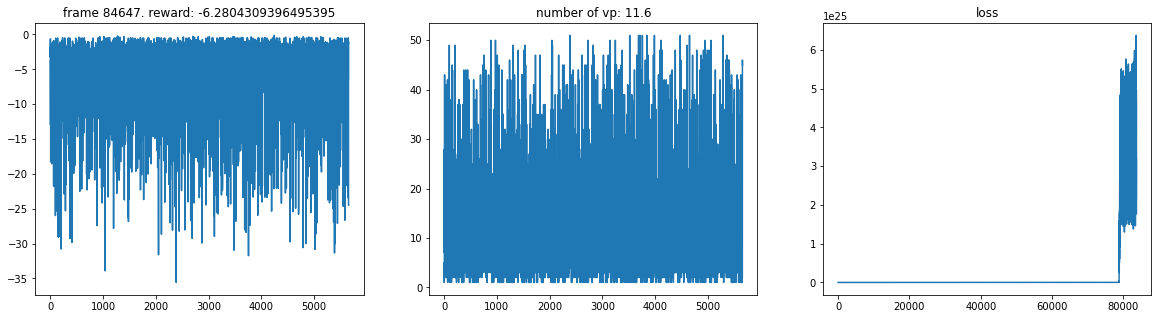

In [8]:
plot(frame_idx, all_rewards, all_nofs, losses)

In [84]:
mesh = env.env.env.env.env.model.mesh
illustrate_mesh(mesh.vertices, mesh.faces)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0, 0…

In [18]:
state, action, mask = env.reset()
for t in range(5):
    action = model.act(state, mask, epsilon=0.0)

    state, reward, done, info, mask = env.step(action)

Action:  75
0.45143494336522094 0.1252558778908177 0.5766908212560387
0.1252558778908177
Action:  63
0.42420329831562886 0.3075599867085257 0.7317632850241546
0.3075599867085257
Action:  63
0.42420329831562886 0.3094923538582842 0.7336956521739131
0.3094923538582842
Action:  63
0.42420329831562886 0.3094923538582842 0.7336956521739131
0.3094923538582842
Action:  63
0.42420329831562886 0.3094923538582842 0.7336956521739131
0.3094923538582842


In [12]:
mask

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [19]:
state   = torch.FloatTensor(np.float32(state)).unsqueeze(0).cuda()
mask = torch.FloatTensor(np.float32(mask)).cuda()

In [49]:
q_value = model.forward(state)

In [50]:
q_value *= mask

In [51]:
q_value = F.softmax(q_value)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [52]:
q_value

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [53]:
q_value.argmax().item()

36

In [54]:
def compute_metrics(env, iter_cnt=10, max_iter=30):
    rewards, final_rewards, novp = [], [], []
    for _ in range(iter_cnt):
        state, action, mask = env.reset()
        episode_reward = 0.0
        for t in range(max_iter):
#             action = model.act(state, mask, epsilon=0.0)
            

            s   = autograd.Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True).cuda()
            m = autograd.Variable(torch.FloatTensor(np.float32(mask)), volatile=True).cuda()
            q_value = model.forward(s)
            q_value *= m
            a = torch.nn.functional.softmax(q_value)
            
            action = a.argmax().item()
            print(action)

            state, reward, done, info, mask = env.step(action)
            # print("REWARD: ", reward)
#             env.render(action, state)
            episode_reward += reward

            if done:
                break

        final_reward = 0
        # final_reward = env.final_reward()
        # episode_reward += 1.0 / final_reward
        rewards.append(episode_reward)
        final_rewards.append(final_reward)
        novp.append(t + 1)
    return np.mean(rewards), np.mean(final_rewards), np.mean(novp)

In [55]:
agent_func = lambda s : model.act(s, epsilon=0.0)
result = compute_metrics(env)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


75
0.45846322352346447 0.007501328236103999 0.46596455175956847
0.007501328236103999
36
0.38924930491195553 0.41681285794445344 0.806062162856409
0.41681285794445344
60
0.4547982138343584 0.36333690047337336 0.8181351143077318
0.36333690047337336
33
0.4140197152245345 0.46807635464446107 0.8820960698689956
0.46807635464446107
83
0.4585896031679164 0.42350646670107917 0.8820960698689956
0.42350646670107917
59
0.4459937652708737 0.44445062209105796 0.8904443873619317
0.44445062209105796
85
0.4557249978936726 0.4388293303878583 0.8945543282815309
0.4388293303878583
98
0.45475608728620776 0.440825726225223 0.8955818135114307
0.440825726225223
13
0.476535512680091 0.4916124451930146 0.9681479578731056
0.4916124451930146
75
0.4717649647887324 0.08067738581875583 0.5524423506074883
0.08067738581875583
36
0.4639964788732394 0.19543818514858052 0.6594346640218199
0.19543818514858052
60
0.4647887323943662 0.24739822520543547 0.7121869575998017
0.24739822520543547
33
0.46307218309859155 0.2692610

0.4856278366111952 0.45664858615303244 0.9422764227642276
0.45664858615303244
88
0.4876449823499748 0.4554444485443342 0.943089430894309
0.4554444485443342
79
0.4868885526979324 0.45620087819637656 0.943089430894309
0.45620087819637656
95
0.402672718103883 0.5412297209205073 0.9439024390243902
0.5412297209205073
9
0.47402924861321233 0.46987319041117787 0.9439024390243902
0.46987319041117787
75
0.4959910430511413 0.3945139414234461 0.8905049844745874
0.3945139414234461
36
0.4826278532216122 0.4654028707528934 0.9480307239745056
0.4654028707528934
60
0.48949003178272177 0.47455638102982933 0.9640464128125511
0.47455638102982933
75
0.4495060373216246 0.2607704793931918 0.7102765167148164
0.2607704793931918
36
0.4339553604098061 0.2895279247738506 0.7234832851836567
0.2895279247738506
60
0.4606659348701061 0.27602411878239086 0.736690053652497
0.27602411878239086
33
0.42993047932674716 0.3174900737066824 0.7474205530334296
0.3174900737066824
83
0.4610318331503842 0.3074370071302597 0.7684

In [56]:
result

(-6.88126904400267, 0.0, 12.2)

In [151]:
print((6 * 256 * 256 * 8) / 1e9 * 3000, 'G')
print((10 * 512 * 512 * 8) / 1e9 * 5000, 'G')
print(1e6 * 10 * 512 * 512 * 4 / 2 ** 40, 'T')
print(1e5 * 64 * 64 * 64 * 4 * 4 / 2 ** 40, 'T')

9.437184 G
104.8576 G
9.5367431640625 T
0.3814697265625 T


In [ ]:
TODO Today:
    1. + check DQN with A, S as input -> send Sergey
    2. + Smaller depth_maps (6 * 256 * 256)
    3. + Illustrate reward as area + novp
    4. + Distributed Buffer
    5. + Buffer on hard disk (memmap)
    6. Floats to int
    7. GPU raycasting
    8. * Greedy algo
    9. * Voxels
    10. CNN different shapes input
    11. Preprocessed depth_maps
    
    10. Overfit experiments 
    11. ABC experiment
    
    12. Experiment radius = 1.0
    13. Experiments with smaller reward fine
    14. Experiment with different DQN-s
    15. ABC - write random model reading
    

Ideas:
    1. Add fine for same view_point
    
Big Experiments:
    1. Voxels
    2. PointNet
    3. Context (N first view_points)
    4. Meta-learning, подавать от простой к сложной детальке

In [15]:
difficult = [
    "00020107_b27a1602d1d44a3d89140ce4_007.obj",
    "00010095_5ae1ee45b583467fa009adc4_006.obj",
    "00010163_ccef4063b69f428e91b498c9_008.obj",
    "00010145_77759770d8cd48af80775d86_002.obj",
    "00010153_556de37e0a7447fcbfbdfd22_000.obj",
    "00010162_ccef4063b69f428e91b498c9_007.obj",
    "00020074_37170a1ba80747f1a1478985_000.obj",
    "00020077_bf146f0c5dee4199be920a21_000.obj",
    "00020080_7a689565e1e0481ca3ad4a6f_000.obj",
    "00010164_ccef4063b69f428e91b498c9_009.obj",
    "00010179_f91d806ac1e34ea1b14e23be_000.obj",
    "00020095_842a932142a9431784488344_000.obj",
    "00020097_e24ecc9c647f4bd1832bfb1d_000.obj",
    "00020106_b27a1602d1d44a3d89140ce4_006.obj",
    "00020141_b27a1602d1d44a3d89140ce4_041.obj",
    "00020155_b27a1602d1d44a3d89140ce4_055.obj",
    "00020186_b27a1602d1d44a3d89140ce4_086.obj",
    "00020202_b27a1602d1d44a3d89140ce4_102.obj",
    "00020203_b27a1602d1d44a3d89140ce4_103.obj",
    "00020213_1f65839d7f6c42bf8c2b3391_000.obj"]